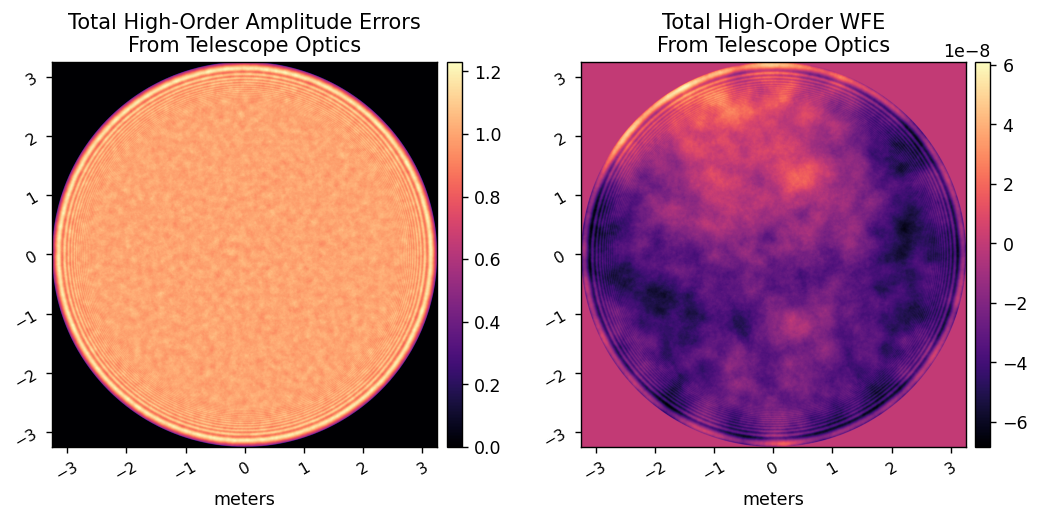

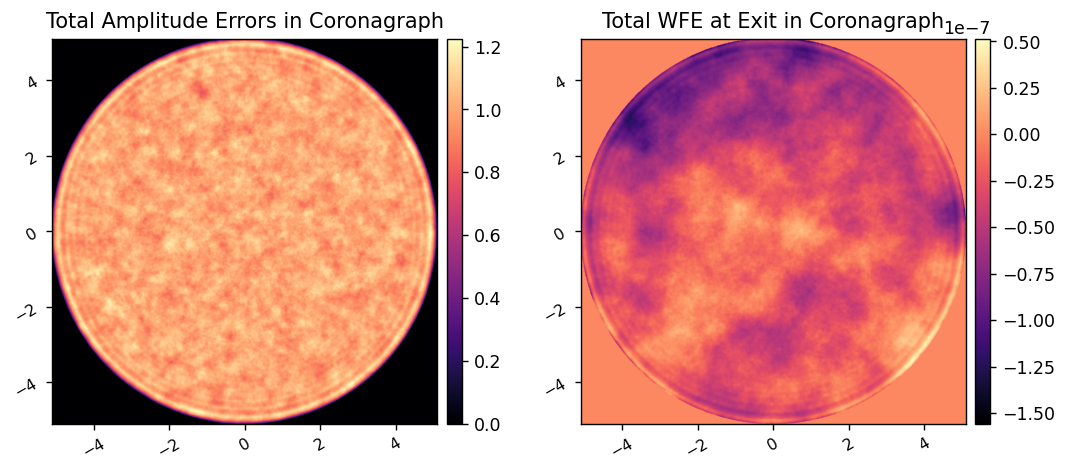

In [3]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
xp = cp if poppy.accel_math._USE_CUPY else np

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

from pop_models import full, compact, agpm
reload(full)
reload(compact)
reload(agpm)

# from wfsc_1dm import efc, pwp, utils
# from imshows import *

import lina
from lina.imshows import *

pupil_diam = 10.2*u.mm
wavelength_c = 650e-9*u.m

focal_ratio = 350/500 # focal lengths of relay OAPs from DM pupil to 
lyot_diam = 0.85 * pupil_diam *focal_ratio

# Load in the OTE WFE for the full model of the coronagraph
ote_wfe_fname = 'ote-wfe-data/telescope_wfe.fits'
wfe_hdu = fits.open(ote_wfe_fname)
wfe = xp.array(wfe_hdu[0].data)
wfe_pxscl = wfe_hdu[0].header['PIXELSCL'] * u.m/u.pix
wfe_hdu.close()
OTE_WFE = poppy.ArrayOpticalElement(transmission=wfe[0], opd=wfe[1], pixelscale=wfe_pxscl,)
imshow2(OTE_WFE.amplitude, OTE_WFE.opd, 
        'Total High-Order Amplitude Errors\nFrom Telescope Optics', 'Total High-Order WFE\nFrom Telescope Optics', 
#         pxscl=OTE_WFE.pixelscale.to(u.mm/u.pix),
        pxscl=6.5/wfe.shape[1], xlabel='meters',
       )

# Load in the pupil plane wfe from the compact model of the coronagraph
wfe_fits = fits.open('phase-retrieval-data/post_fpm_pupil_wfe.fits')
coro_wfe = np.fliplr(wfe_fits[0].data)
wfe_pxscl = wfe_fits[0].header['PIXELSCL'] * u.m/u.pix
wfe_fits.close()
CORO_WFE = poppy.ArrayOpticalElement(transmission=coro_wfe[0], opd=coro_wfe[1],pixelscale=wfe_pxscl,)
imshow2(CORO_WFE.amplitude, CORO_WFE.opd, 
        'Total Amplitude Errors in Coronagraph', 'Total WFE at Exit in Coronagraph',
        pxscl=CORO_WFE.pixelscale.to(u.mm/u.pix))

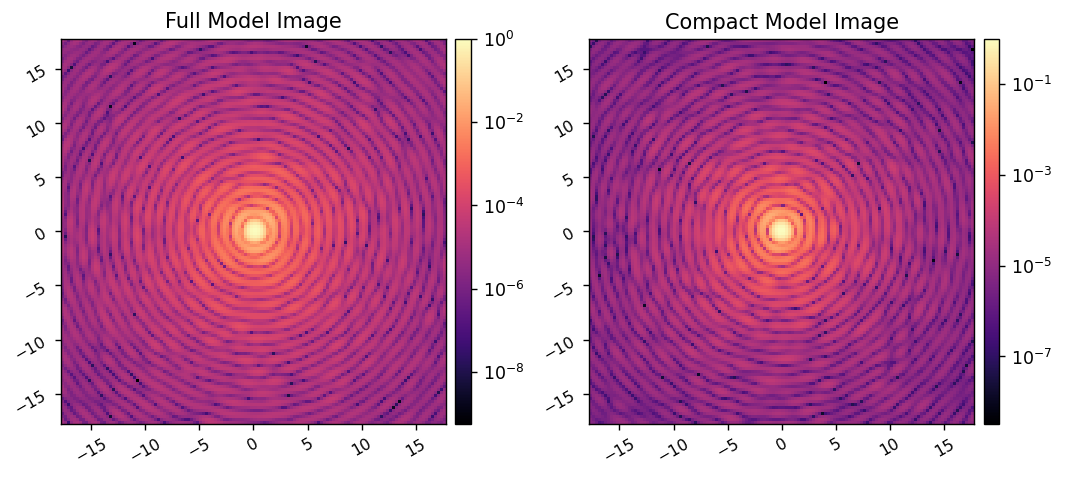

In [4]:
reload(full)
reload(compact)

reload(agpm)

coro = full.CORO()
coro.npix = 512
coro.oversample = 8
coro.npsf = 128
coro.use_opds = True
coro.OTEWFE = OTE_WFE

model = compact.CORO()
model.npix = 512
model.oversample = 8
model.npsf = 128
model.RETRIEVED = CORO_WFE

coro.im_norm = coro.snap().max()
model.im_norm = model.snap().max()

ref_psf = coro.snap()
model_psf = model.snap()

imshow2(ref_psf, model_psf, 'Full Model Image', 'Compact Model Image', lognorm=True,
             pxscl1=coro.psf_pixelscale_lamD, pxscl2=model.psf_pixelscale_lamD)

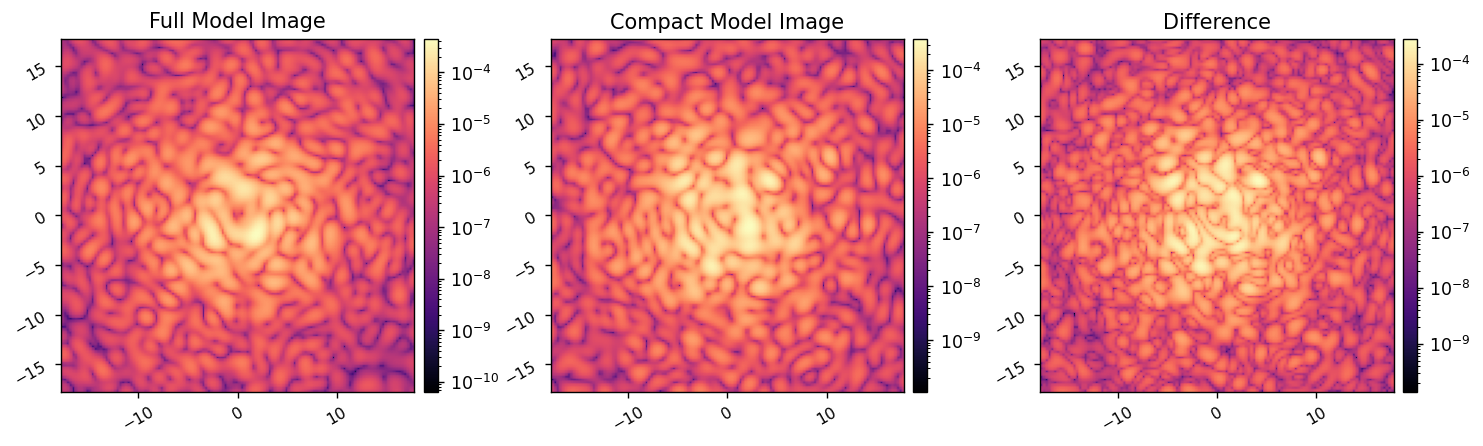

In [5]:
vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
vortex_model = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6)

lyot_stop = poppy.CircularAperture(radius=lyot_diam/2)
lyot_stop_model = poppy.CircularAperture(radius=lyot_diam/2 / focal_ratio)

coro.FPM = vortex
coro.LYOT = lyot_stop

model.FPM = vortex_model
model.LYOT = lyot_stop_model

ref_im = coro.snap()
model_im = model.snap()

imshow3(ref_im, model_im, xp.abs(ref_im-model_im),
        'Full Model Image', 'Compact Model Image', 'Difference',
        lognorm1=True, lognorm2=True, lognorm3=True,
        pxscl=coro.psf_pixelscale_lamD)

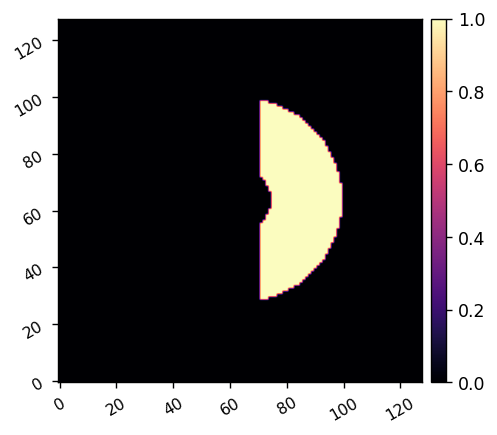

In [6]:
reload(lina.utils)
iwa = 3
owa = 10
edge = 2
control_mask = lina.utils.create_annular_focal_plane_mask(model, iwa, owa, edge=edge, shift=(0,0), rotation=0, plot=True)


In [10]:
control_mask.sum()*2, 952

(array(2964), 952)

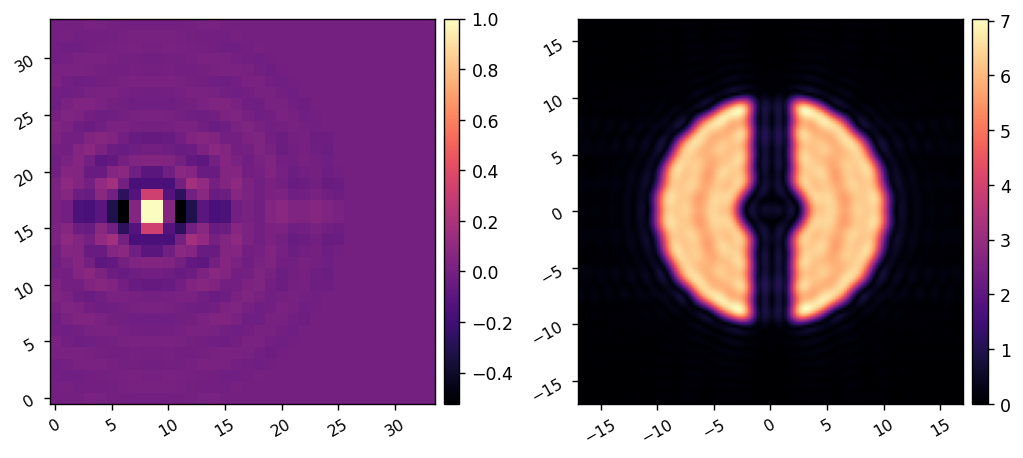

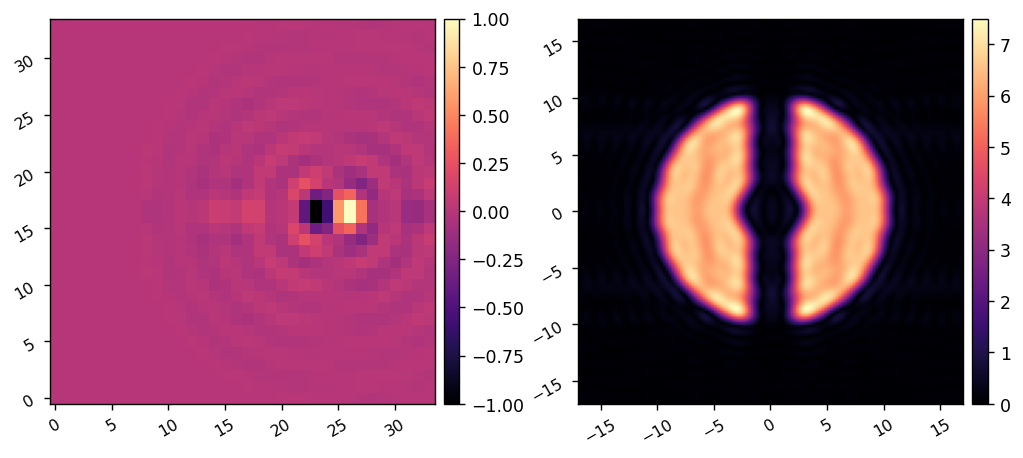

In [7]:
reload(lina.utils)
Npairs = 2

probe_amp = 5e-8
probe_radius = 14
probe_offset = (0,0)

# probes = lina.utils.create_sinc_probes(Npairs, coro.Nact, coro.dm_mask, probe_amp, probe_radius, probe_offset, 
#                                        plot=True)
probe_amp = 2e-8
probes = probe_amp * lina.utils.create_fourier_probes(coro, control_mask, fourier_sampling=0.2, shift=[(-8,0), (8,0)], nprobes=2, 
                                          plot=True, calc_responses=True)

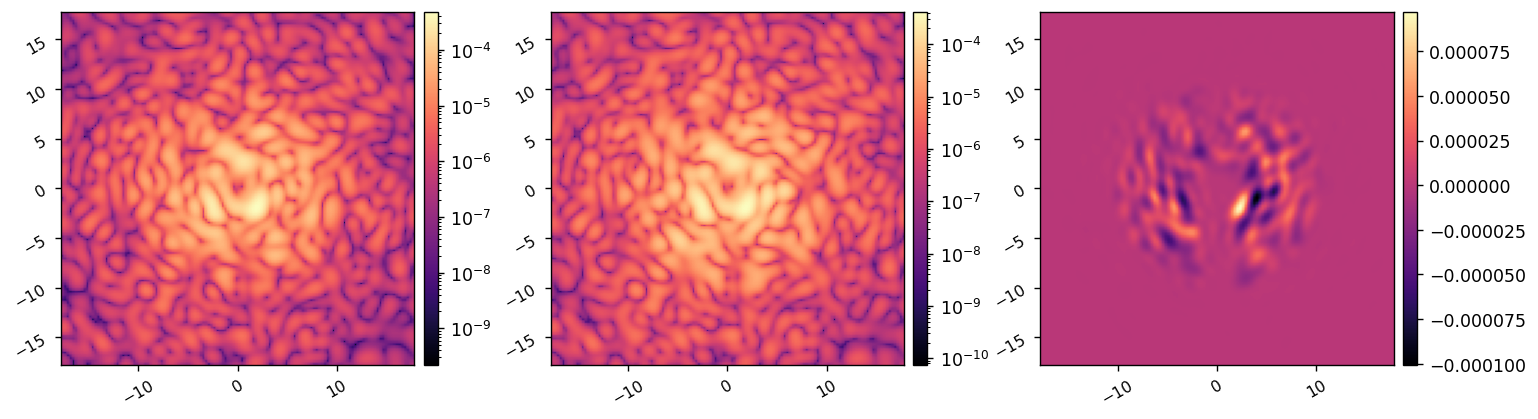

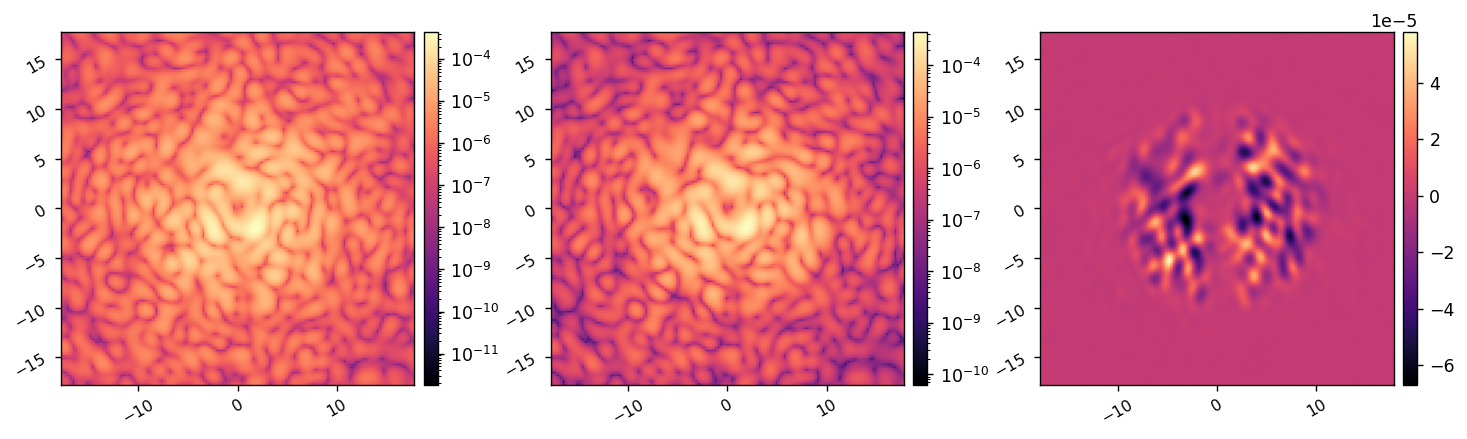

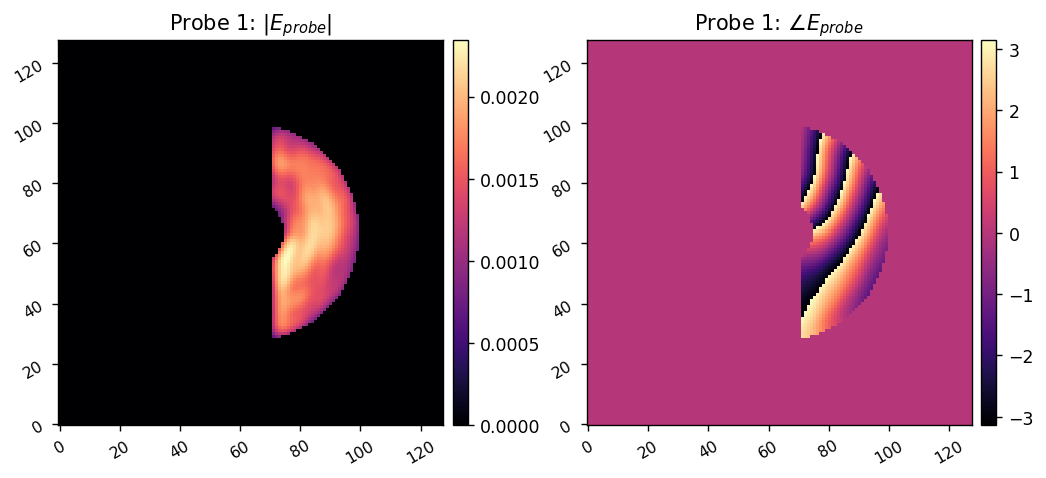

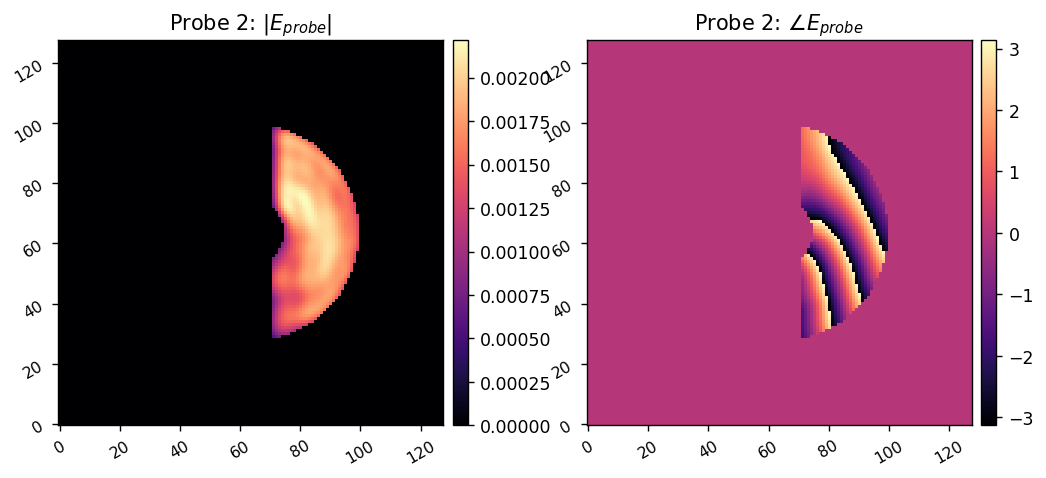

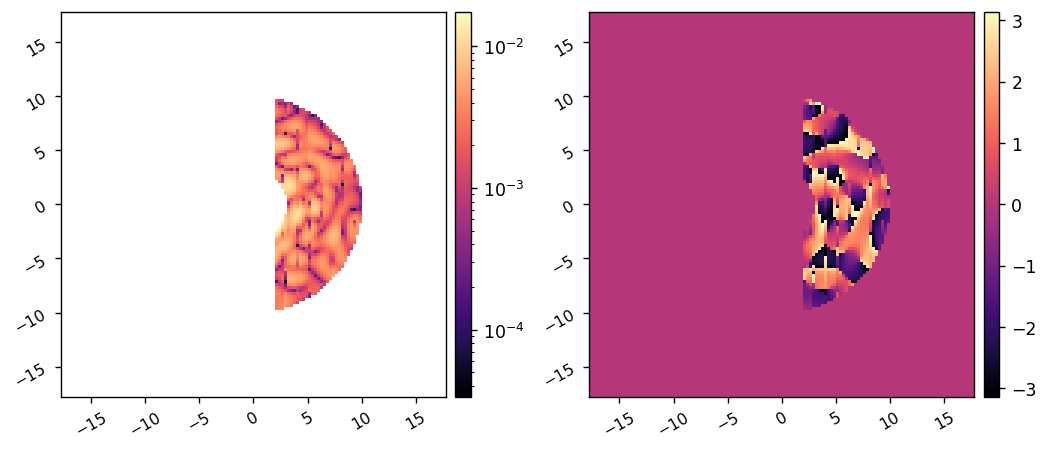

In [8]:
reload(lina.pwp)
coro.reset_dm()
E_est = lina.pwp.run_pwp_bp(coro, control_mask, probes, use='model', model=coro, plot=True, plot_est=True)
# I_est = np.abs(E_est)**2
# P_est = np.angle(E_est)
# misc.imshow2(I_est, P_est, lognorm1=True)

# diff = ref_im*control_mask - I_est
# imshow3(ref_im*control_mask, I_est, diff,
#         lognorm1=True, lognorm2=True)

In [18]:
reload(efc)

cc.reset_dm()
epsilon = 1e-9 # poke amplitudes (DM surface)
jac = efc.build_jacobian(cc, epsilon, dark_mask.flatten(), display=False)

	Calculated response for mode 1/952. Elapsed time=0.992 sec.
	Calculated response for mode 2/952. Elapsed time=1.289 sec.
	Calculated response for mode 3/952. Elapsed time=1.573 sec.
	Calculated response for mode 4/952. Elapsed time=1.861 sec.
	Calculated response for mode 5/952. Elapsed time=2.146 sec.
	Calculated response for mode 6/952. Elapsed time=2.432 sec.
	Calculated response for mode 7/952. Elapsed time=2.714 sec.
	Calculated response for mode 8/952. Elapsed time=2.994 sec.
	Calculated response for mode 9/952. Elapsed time=3.273 sec.
	Calculated response for mode 10/952. Elapsed time=3.553 sec.
	Calculated response for mode 11/952. Elapsed time=3.833 sec.
	Calculated response for mode 12/952. Elapsed time=4.118 sec.
	Calculated response for mode 13/952. Elapsed time=4.424 sec.
	Calculated response for mode 14/952. Elapsed time=4.703 sec.
	Calculated response for mode 15/952. Elapsed time=4.978 sec.
	Calculated response for mode 16/952. Elapsed time=5.260 sec.
	Calculated respo

	Calculated response for mode 132/952. Elapsed time=38.036 sec.
	Calculated response for mode 133/952. Elapsed time=38.309 sec.
	Calculated response for mode 134/952. Elapsed time=38.581 sec.
	Calculated response for mode 135/952. Elapsed time=38.854 sec.
	Calculated response for mode 136/952. Elapsed time=39.128 sec.
	Calculated response for mode 137/952. Elapsed time=39.404 sec.
	Calculated response for mode 138/952. Elapsed time=39.691 sec.
	Calculated response for mode 139/952. Elapsed time=39.978 sec.
	Calculated response for mode 140/952. Elapsed time=40.263 sec.
	Calculated response for mode 141/952. Elapsed time=40.548 sec.
	Calculated response for mode 142/952. Elapsed time=40.833 sec.
	Calculated response for mode 143/952. Elapsed time=41.113 sec.
	Calculated response for mode 144/952. Elapsed time=41.393 sec.
	Calculated response for mode 145/952. Elapsed time=41.668 sec.
	Calculated response for mode 146/952. Elapsed time=41.948 sec.
	Calculated response for mode 147/952. E

	Calculated response for mode 261/952. Elapsed time=74.403 sec.
	Calculated response for mode 262/952. Elapsed time=74.688 sec.
	Calculated response for mode 263/952. Elapsed time=75.008 sec.
	Calculated response for mode 264/952. Elapsed time=75.316 sec.
	Calculated response for mode 265/952. Elapsed time=75.603 sec.
	Calculated response for mode 266/952. Elapsed time=75.913 sec.
	Calculated response for mode 267/952. Elapsed time=76.195 sec.
	Calculated response for mode 268/952. Elapsed time=76.479 sec.
	Calculated response for mode 269/952. Elapsed time=76.765 sec.
	Calculated response for mode 270/952. Elapsed time=77.048 sec.
	Calculated response for mode 271/952. Elapsed time=77.333 sec.
	Calculated response for mode 272/952. Elapsed time=77.613 sec.
	Calculated response for mode 273/952. Elapsed time=77.913 sec.
	Calculated response for mode 274/952. Elapsed time=78.189 sec.
	Calculated response for mode 275/952. Elapsed time=78.481 sec.
	Calculated response for mode 276/952. E

	Calculated response for mode 389/952. Elapsed time=111.699 sec.
	Calculated response for mode 390/952. Elapsed time=111.986 sec.
	Calculated response for mode 391/952. Elapsed time=112.268 sec.
	Calculated response for mode 392/952. Elapsed time=112.548 sec.
	Calculated response for mode 393/952. Elapsed time=112.844 sec.
	Calculated response for mode 394/952. Elapsed time=113.134 sec.
	Calculated response for mode 395/952. Elapsed time=113.432 sec.
	Calculated response for mode 396/952. Elapsed time=113.717 sec.
	Calculated response for mode 397/952. Elapsed time=113.999 sec.
	Calculated response for mode 398/952. Elapsed time=114.288 sec.
	Calculated response for mode 399/952. Elapsed time=114.574 sec.
	Calculated response for mode 400/952. Elapsed time=114.878 sec.
	Calculated response for mode 401/952. Elapsed time=115.167 sec.
	Calculated response for mode 402/952. Elapsed time=115.453 sec.
	Calculated response for mode 403/952. Elapsed time=115.740 sec.
	Calculated response for 

	Calculated response for mode 516/952. Elapsed time=148.370 sec.
	Calculated response for mode 517/952. Elapsed time=148.656 sec.
	Calculated response for mode 518/952. Elapsed time=148.940 sec.
	Calculated response for mode 519/952. Elapsed time=149.211 sec.
	Calculated response for mode 520/952. Elapsed time=149.494 sec.
	Calculated response for mode 521/952. Elapsed time=149.774 sec.
	Calculated response for mode 522/952. Elapsed time=150.053 sec.
	Calculated response for mode 523/952. Elapsed time=150.329 sec.
	Calculated response for mode 524/952. Elapsed time=150.614 sec.
	Calculated response for mode 525/952. Elapsed time=150.889 sec.
	Calculated response for mode 526/952. Elapsed time=151.168 sec.
	Calculated response for mode 527/952. Elapsed time=151.443 sec.
	Calculated response for mode 528/952. Elapsed time=151.728 sec.
	Calculated response for mode 529/952. Elapsed time=152.012 sec.
	Calculated response for mode 530/952. Elapsed time=152.298 sec.
	Calculated response for 

	Calculated response for mode 643/952. Elapsed time=184.069 sec.
	Calculated response for mode 644/952. Elapsed time=184.354 sec.
	Calculated response for mode 645/952. Elapsed time=184.636 sec.
	Calculated response for mode 646/952. Elapsed time=184.918 sec.
	Calculated response for mode 647/952. Elapsed time=185.201 sec.
	Calculated response for mode 648/952. Elapsed time=185.478 sec.
	Calculated response for mode 649/952. Elapsed time=185.768 sec.
	Calculated response for mode 650/952. Elapsed time=186.047 sec.
	Calculated response for mode 651/952. Elapsed time=186.330 sec.
	Calculated response for mode 652/952. Elapsed time=186.608 sec.
	Calculated response for mode 653/952. Elapsed time=186.892 sec.
	Calculated response for mode 654/952. Elapsed time=187.168 sec.
	Calculated response for mode 655/952. Elapsed time=187.450 sec.
	Calculated response for mode 656/952. Elapsed time=187.733 sec.
	Calculated response for mode 657/952. Elapsed time=188.012 sec.
	Calculated response for 

	Calculated response for mode 770/952. Elapsed time=219.847 sec.
	Calculated response for mode 771/952. Elapsed time=220.128 sec.
	Calculated response for mode 772/952. Elapsed time=220.411 sec.
	Calculated response for mode 773/952. Elapsed time=220.698 sec.
	Calculated response for mode 774/952. Elapsed time=220.977 sec.
	Calculated response for mode 775/952. Elapsed time=221.266 sec.
	Calculated response for mode 776/952. Elapsed time=221.548 sec.
	Calculated response for mode 777/952. Elapsed time=221.827 sec.
	Calculated response for mode 778/952. Elapsed time=222.113 sec.
	Calculated response for mode 779/952. Elapsed time=222.398 sec.
	Calculated response for mode 780/952. Elapsed time=222.679 sec.
	Calculated response for mode 781/952. Elapsed time=222.958 sec.
	Calculated response for mode 782/952. Elapsed time=223.239 sec.
	Calculated response for mode 783/952. Elapsed time=223.528 sec.
	Calculated response for mode 784/952. Elapsed time=223.808 sec.
	Calculated response for 

	Calculated response for mode 897/952. Elapsed time=255.682 sec.
	Calculated response for mode 898/952. Elapsed time=255.967 sec.
	Calculated response for mode 899/952. Elapsed time=256.253 sec.
	Calculated response for mode 900/952. Elapsed time=256.527 sec.
	Calculated response for mode 901/952. Elapsed time=256.809 sec.
	Calculated response for mode 902/952. Elapsed time=257.092 sec.
	Calculated response for mode 903/952. Elapsed time=257.377 sec.
	Calculated response for mode 904/952. Elapsed time=257.663 sec.
	Calculated response for mode 905/952. Elapsed time=257.948 sec.
	Calculated response for mode 906/952. Elapsed time=258.229 sec.
	Calculated response for mode 907/952. Elapsed time=258.514 sec.
	Calculated response for mode 908/952. Elapsed time=258.797 sec.
	Calculated response for mode 909/952. Elapsed time=259.084 sec.
	Calculated response for mode 910/952. Elapsed time=259.412 sec.
	Calculated response for mode 911/952. Elapsed time=259.701 sec.
	Calculated response for 

In [20]:
import misc_funs as misc
misc.save_fits('jacobians\jacobian_20230530.fits', jac, header={'NACTS':952, 'NMASK':int(dark_mask.sum())})

Saved data to:  jacobians\jacobian_20230530.fits


In [5]:
jac = fits.getdata('jacobians\jacobian_20230323.fits')
print(jac.shape, jac.size)

(4084, 952) 3887968


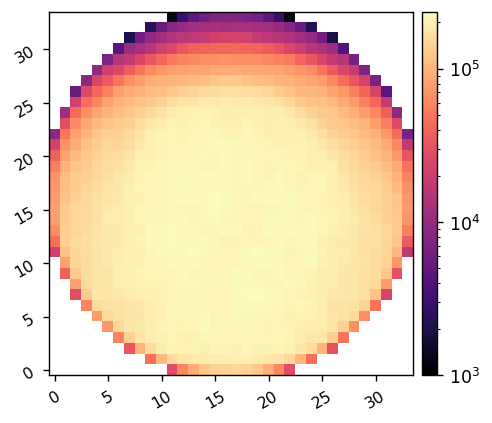

In [21]:
reload(utils)
response = utils.map_acts_to_dm(xp.sqrt(((jac)**2).sum(axis=0)), cc.dm_mask)
imshow1(response, lognorm=True, vmin=1e3)

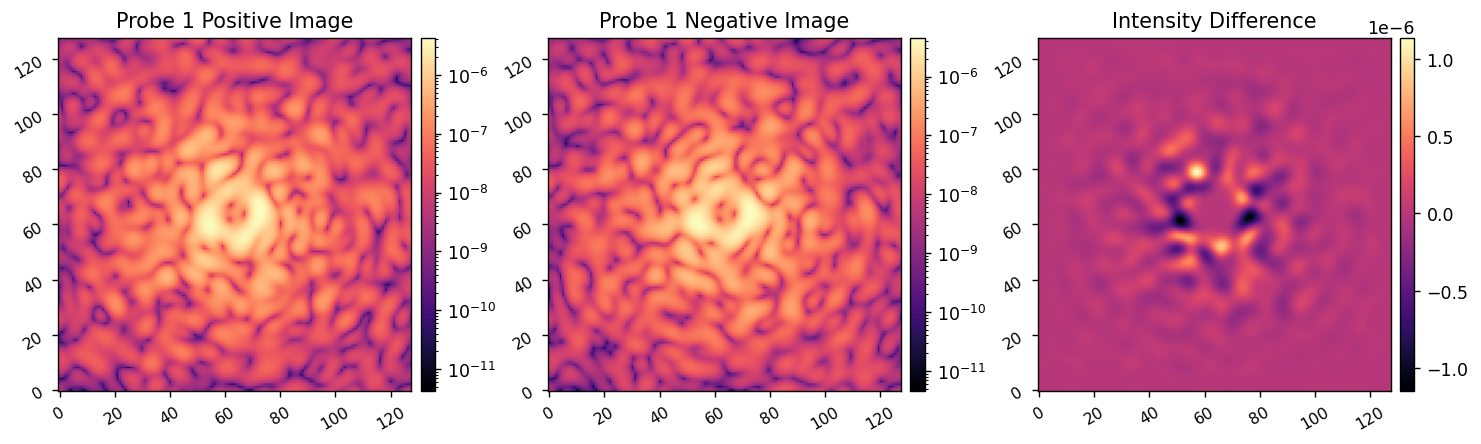

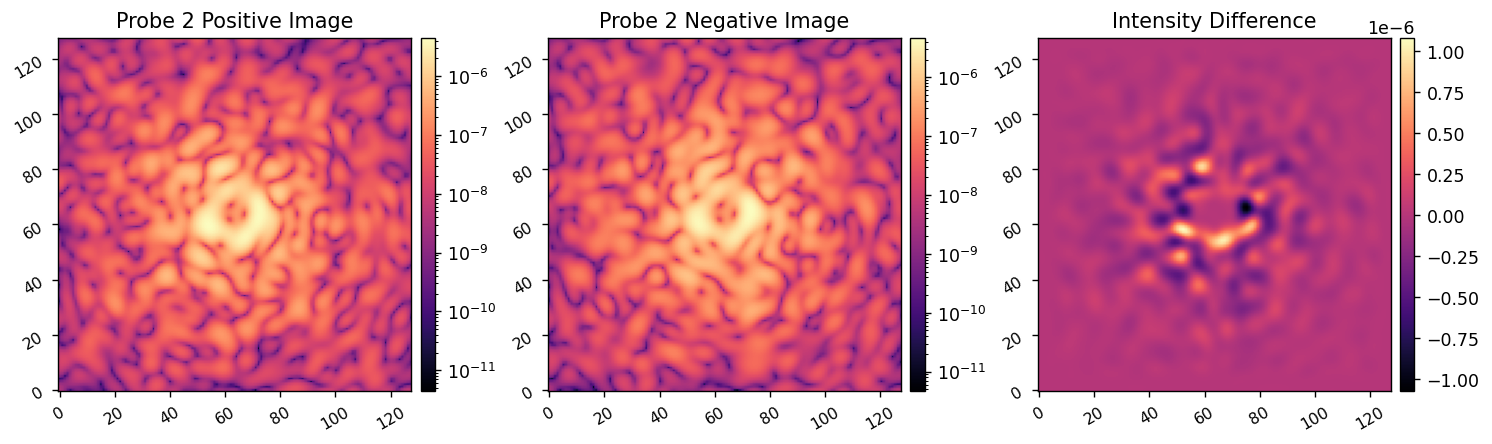

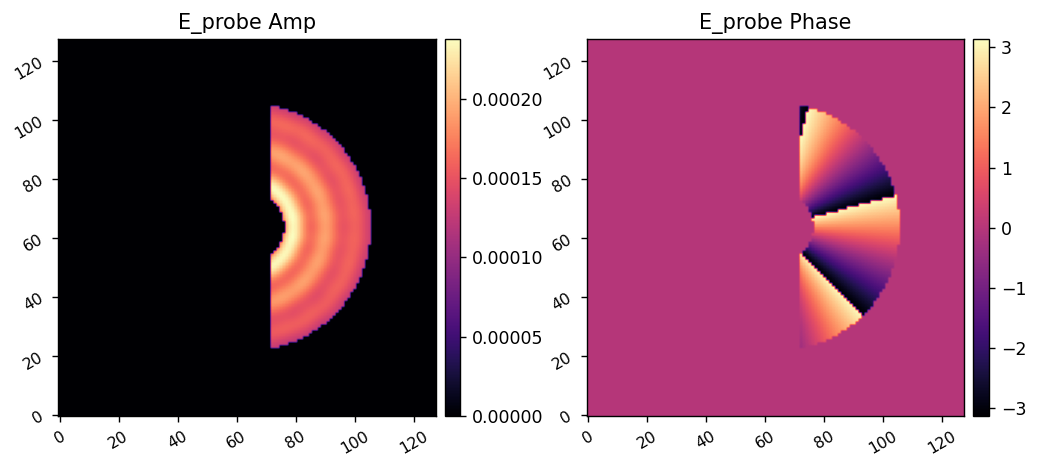

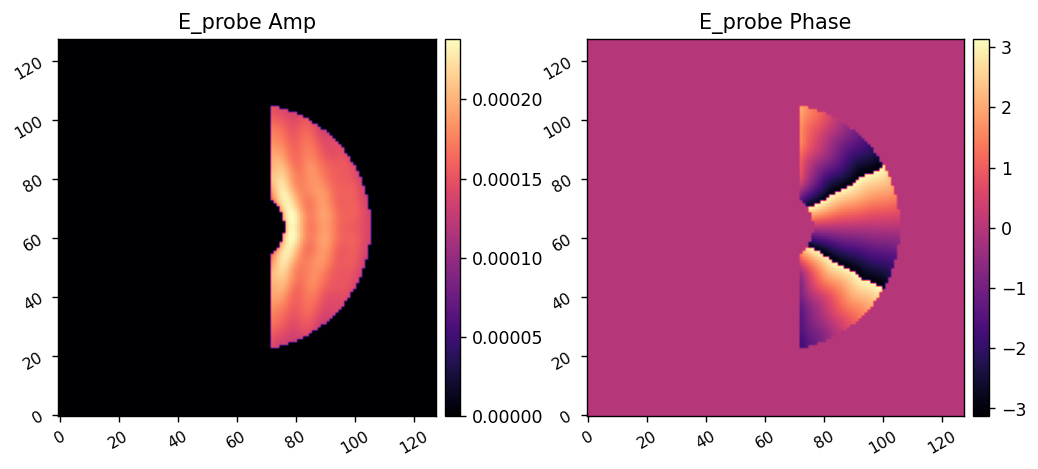

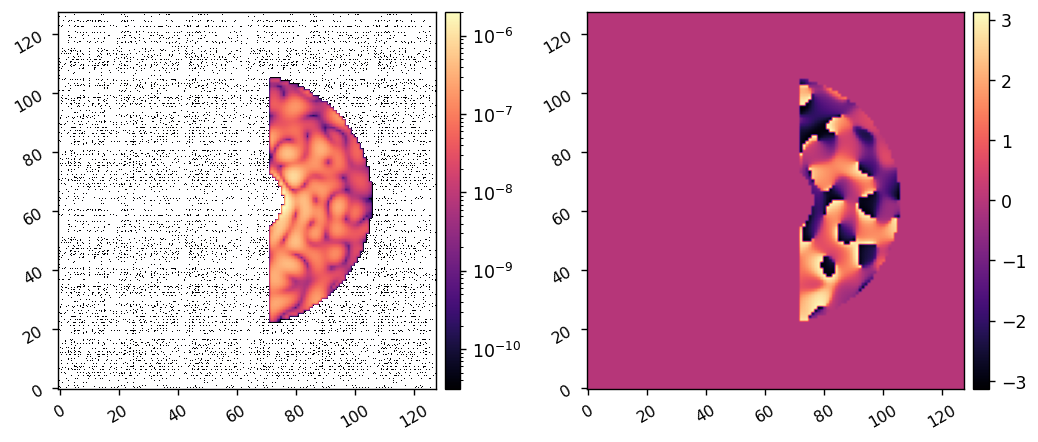

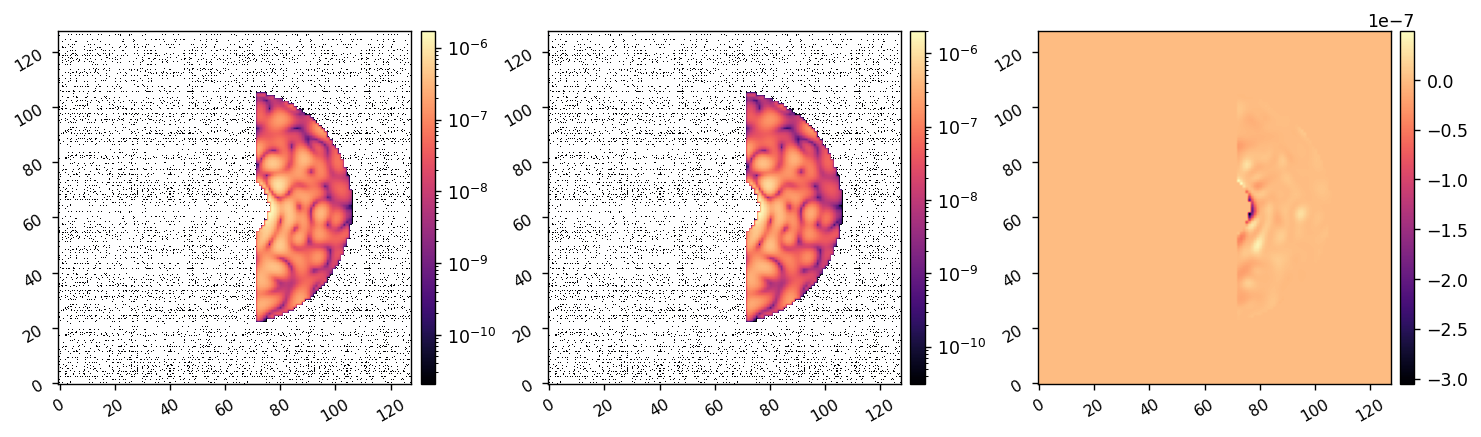

In [13]:
reload(pwp)
fc.reset_dm()
E_est = pwp.run_pwp_bp(fc, dark_mask, probes, use='j', jacobian=jac/2, display=True, display_probe_field=True)
I_est = np.abs(E_est)**2
P_est = np.angle(E_est)
misc.imshow2(I_est, P_est, lognorm1=True)

diff = ref_im*dark_mask - I_est
misc.imshow3(ref_im*dark_mask, I_est, diff,
             lognorm1=True, lognorm2=True)

Beginning closed-loop EFC simulation.
Max singular value squared:	 285240371966.18756
alpha^2:			 46215928553.055916
	Running iteration 0/10.
	Computing EFC matrix via beta_reg with condition value -2.00e+00
Estimation and exact image match factor is 1.046


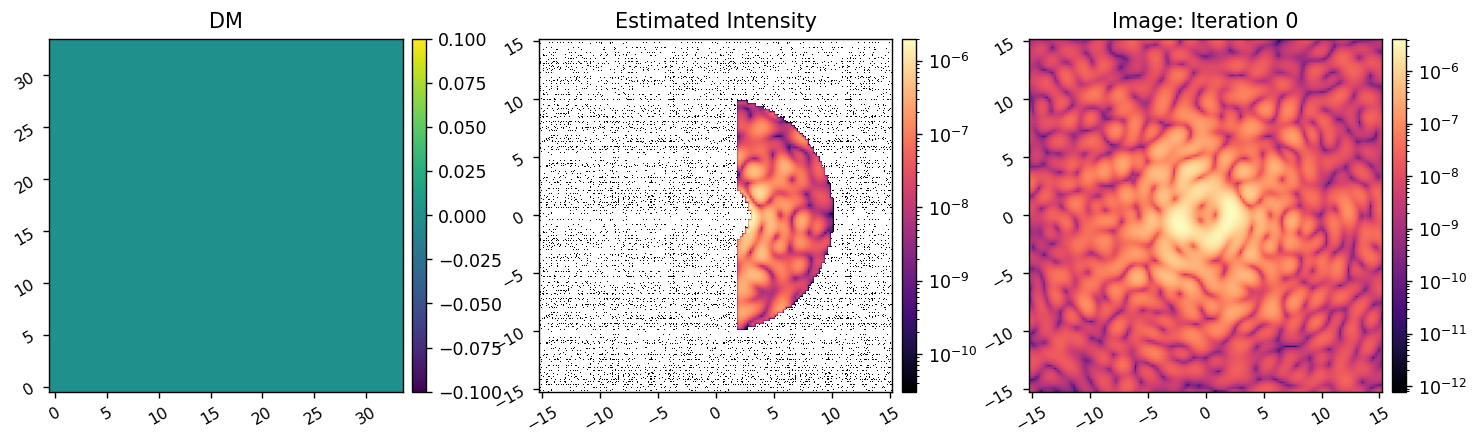

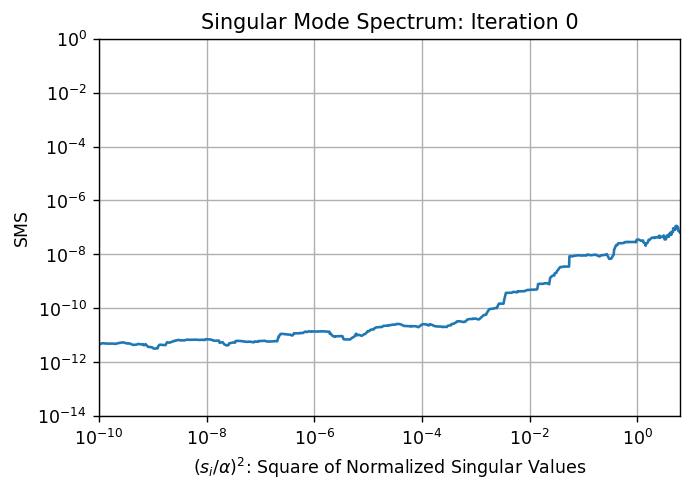

	Running iteration 1/10.
Estimation and exact image match factor is 1.043


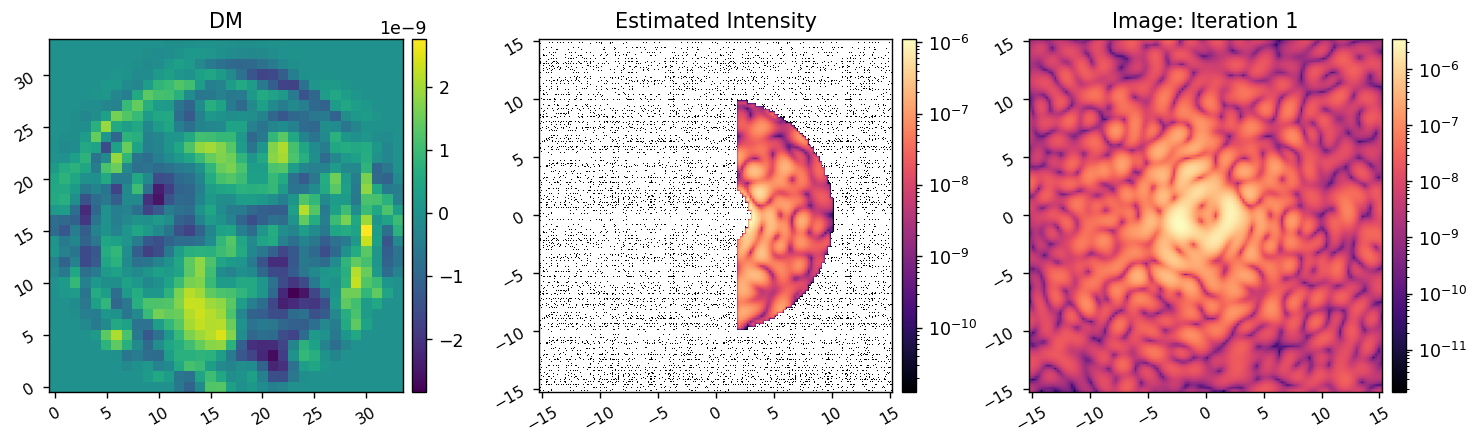

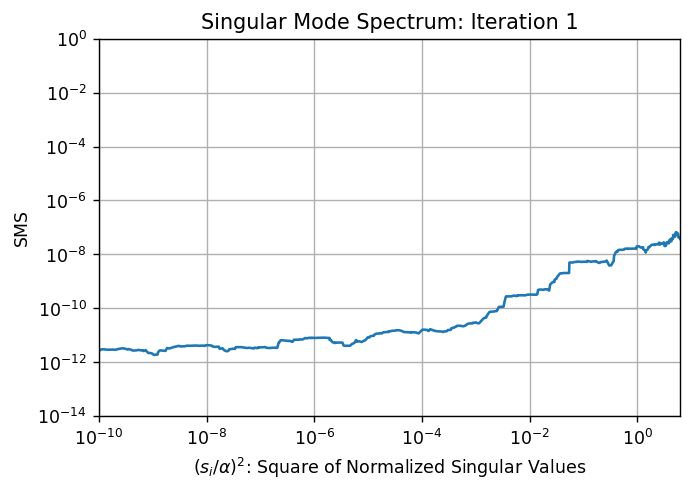

	Running iteration 2/10.
Estimation and exact image match factor is 1.039


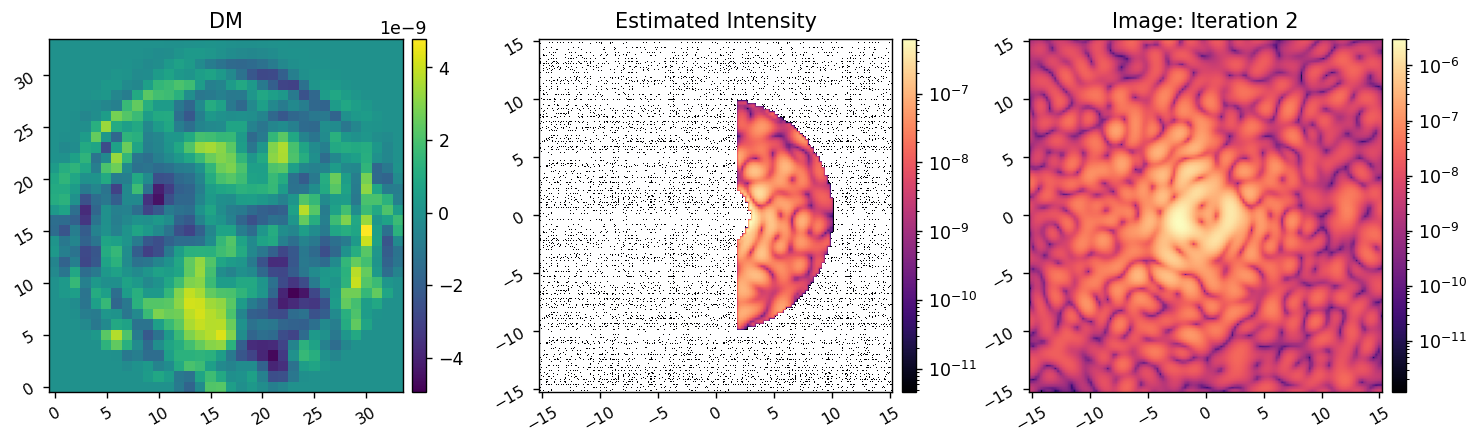

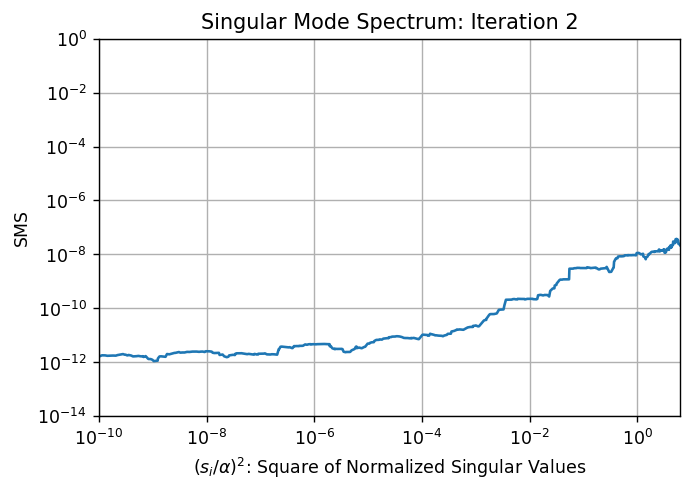

	Running iteration 3/10.
Estimation and exact image match factor is 1.035


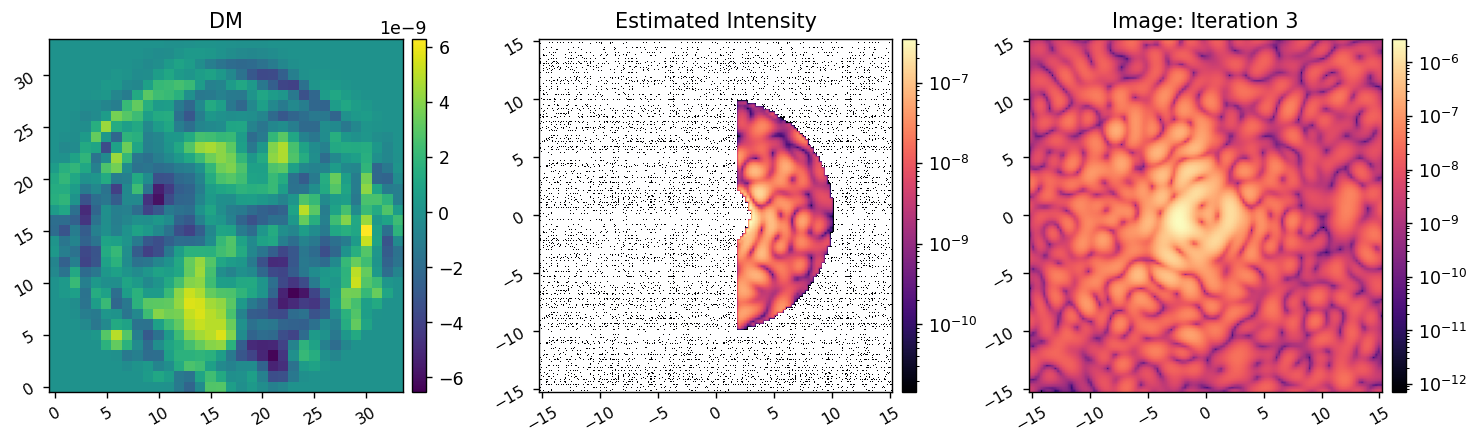

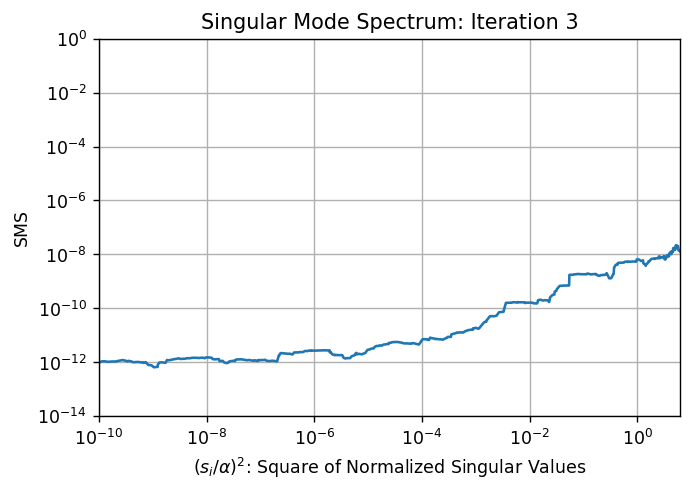

	Running iteration 4/10.
Estimation and exact image match factor is 1.028


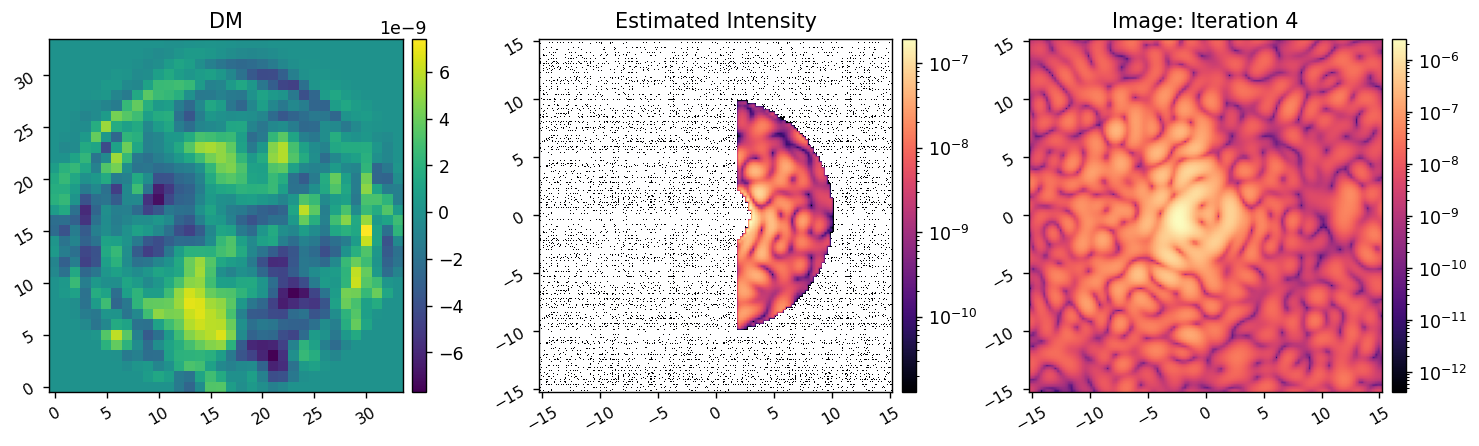

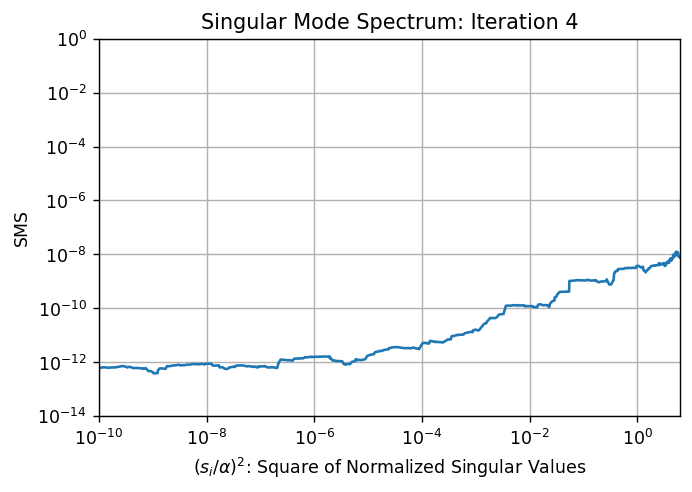

	Running iteration 5/10.
Estimation and exact image match factor is 1.019


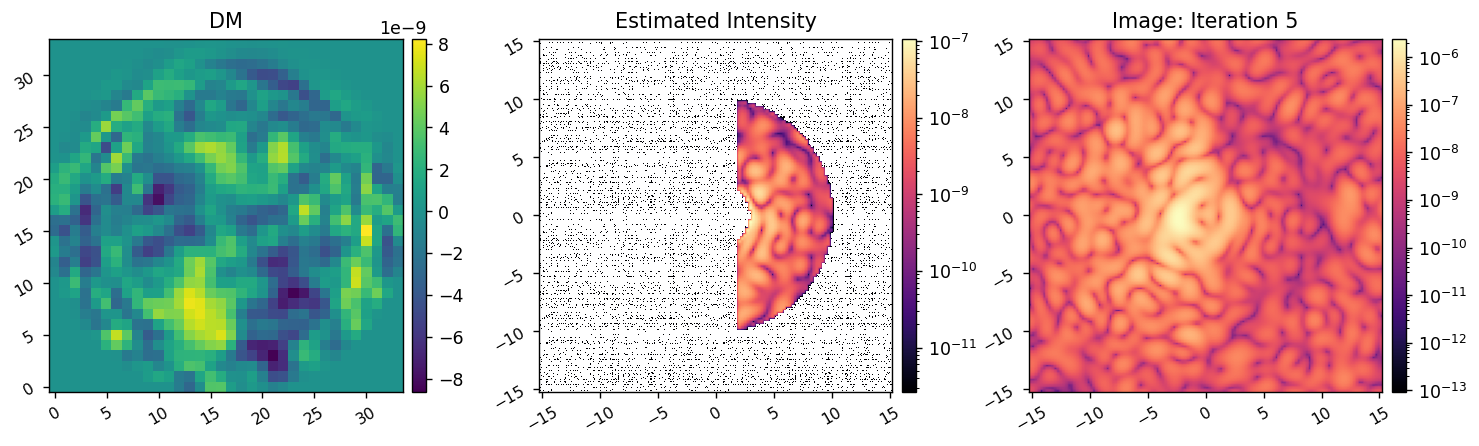

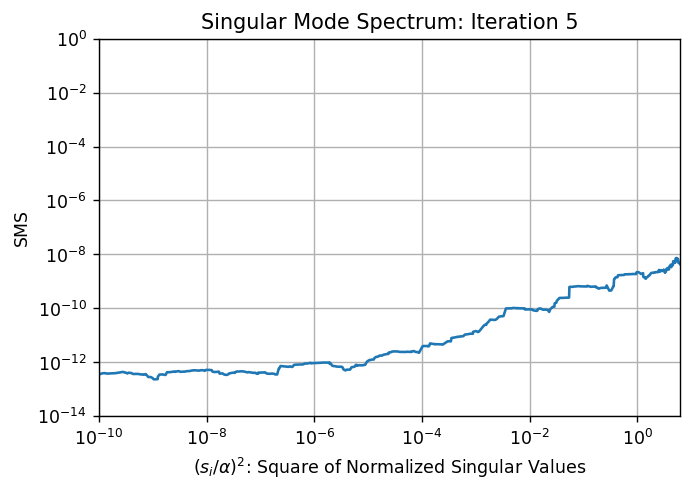

	Running iteration 6/10.
Estimation and exact image match factor is 1.005


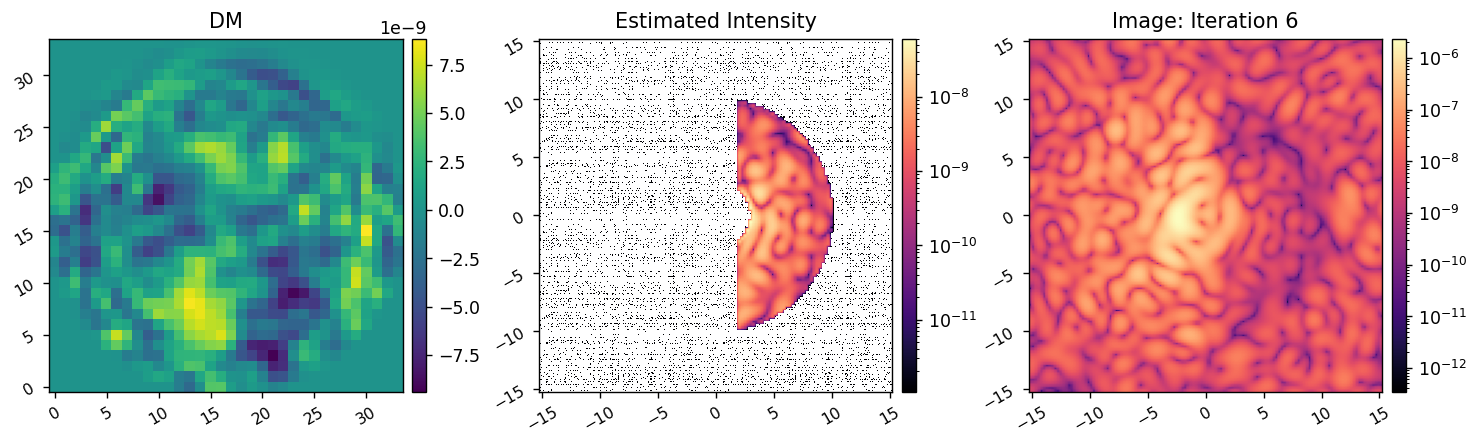

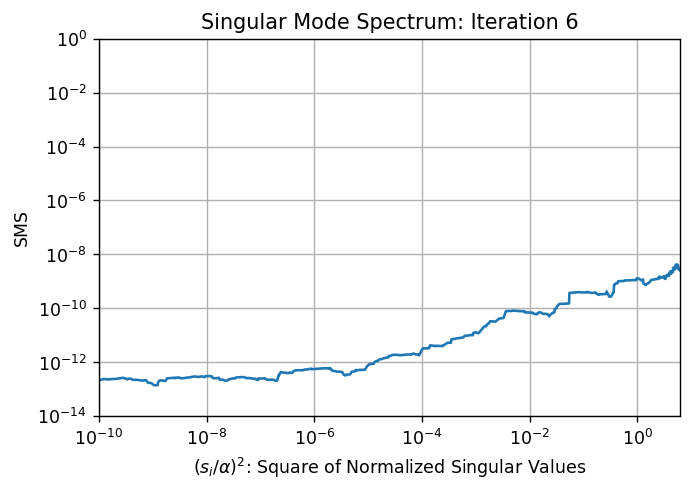

	Running iteration 7/10.
Estimation and exact image match factor is 0.983


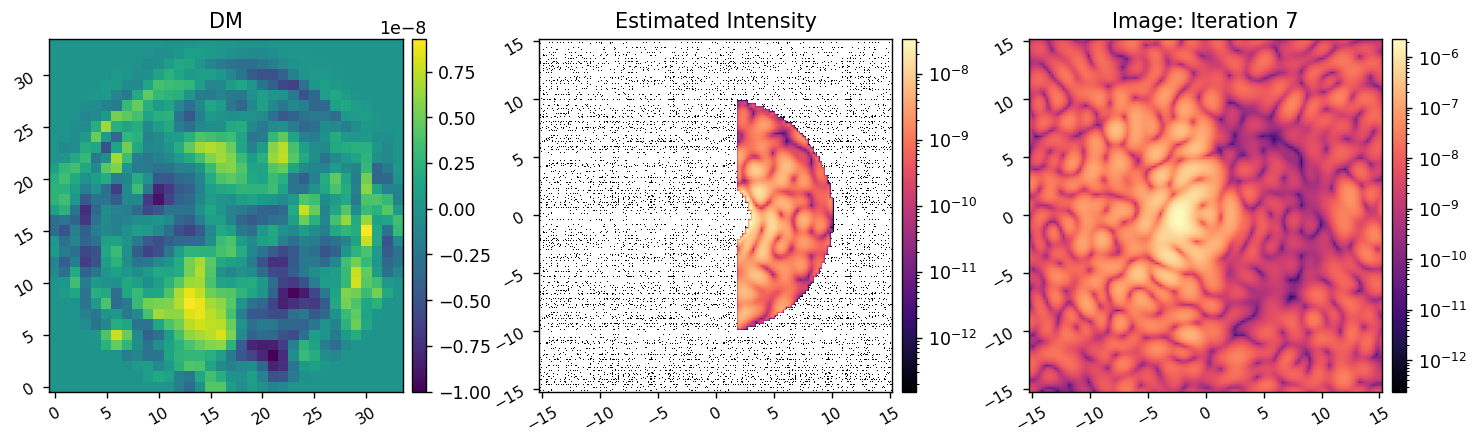

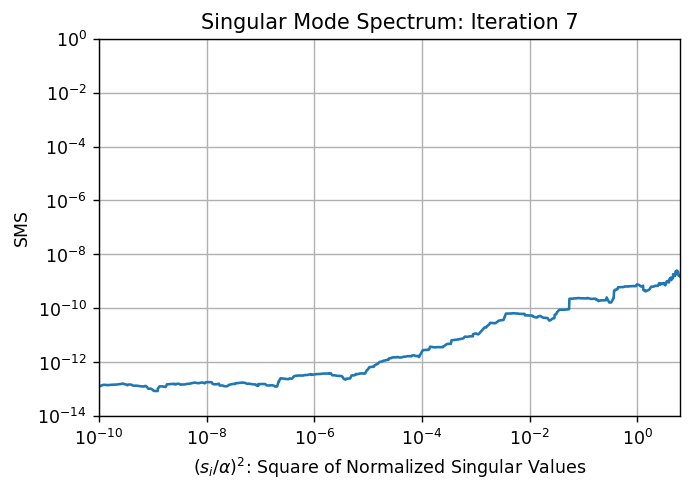

	Running iteration 8/10.
Estimation and exact image match factor is 0.950


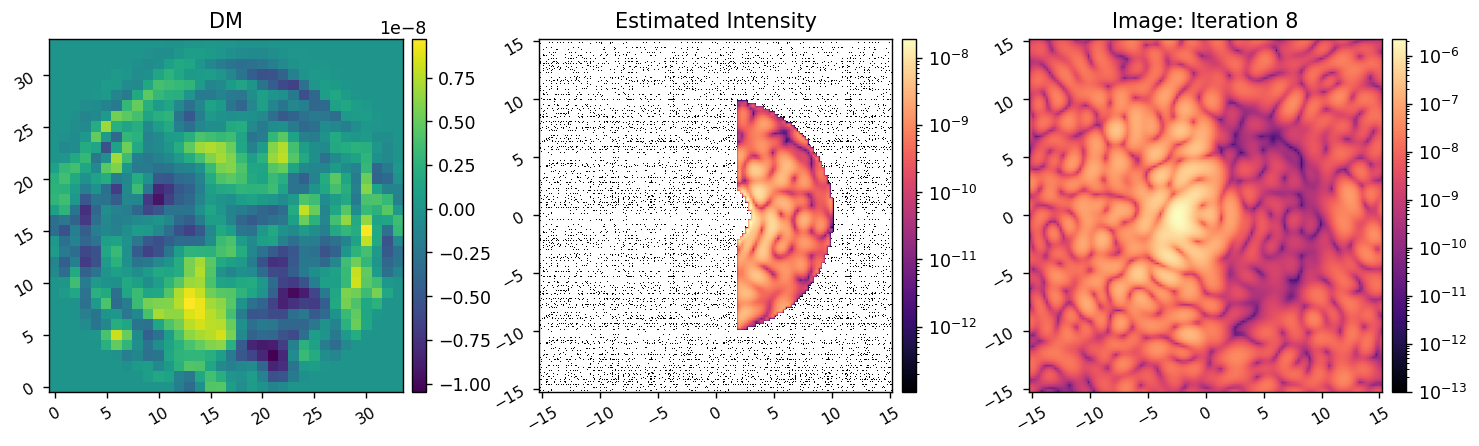

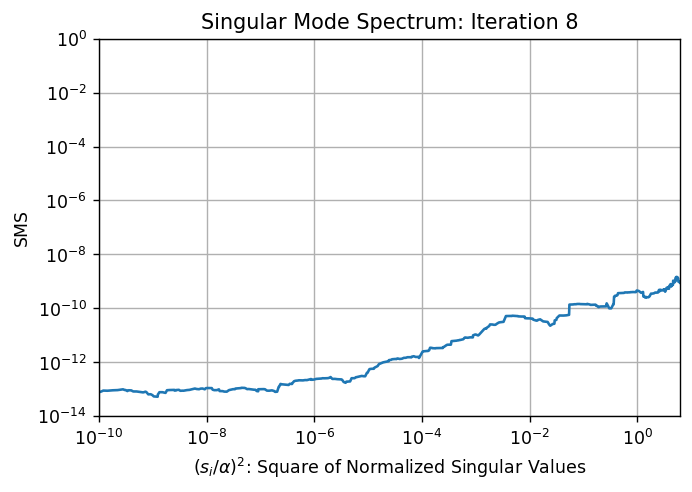

	Running iteration 9/10.
Estimation and exact image match factor is 0.900


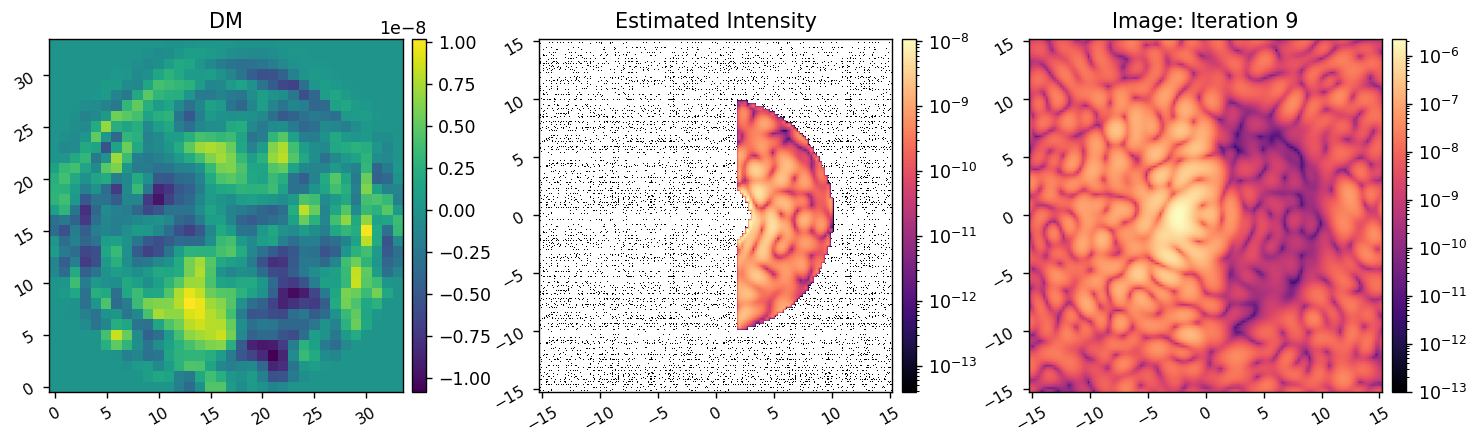

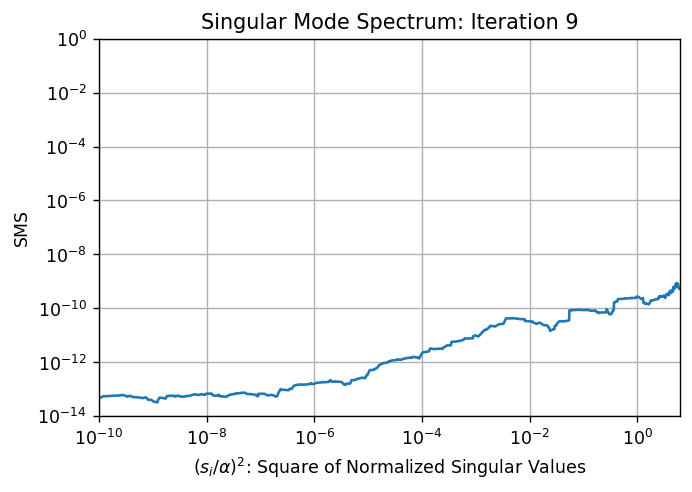

	Running iteration 10/10.
Estimation and exact image match factor is 0.829


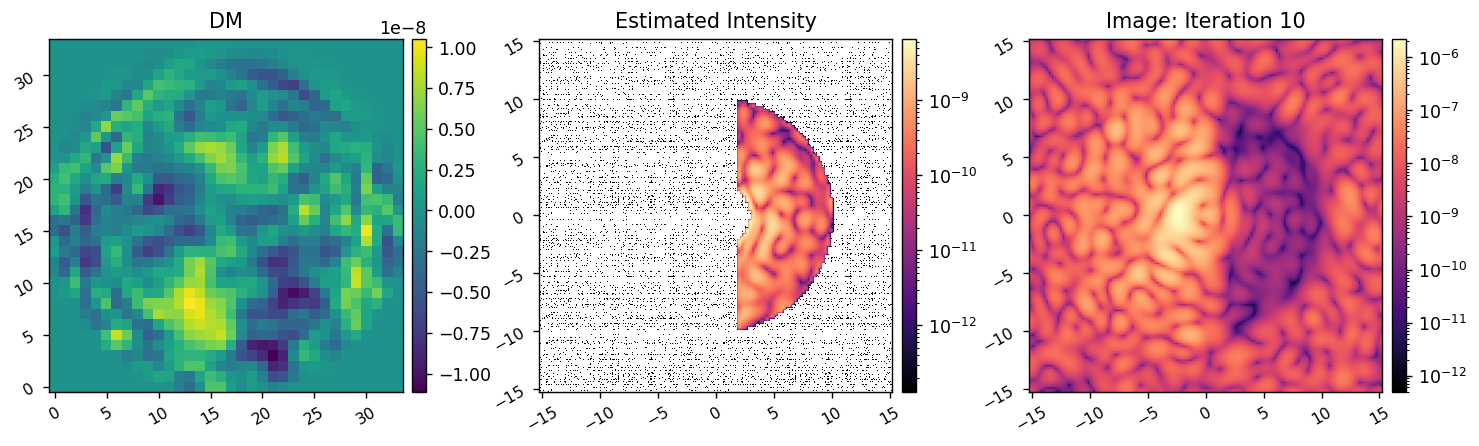

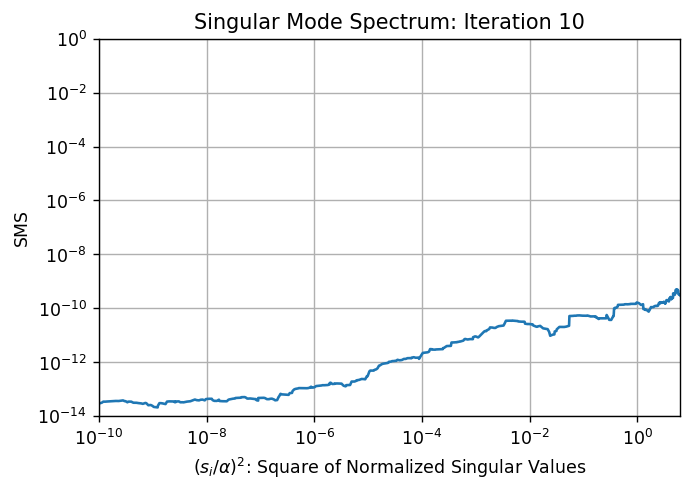

EFC completed in 40.594 sec.


In [14]:
reload(efc)

pwp_fun = pwp.run_pwp_bp
pwp_kwargs = {'probes':probes, 'use':'j', 'jacobian':jac/2, 
              'display':False, 'display_probe_field':False}


reg_fun = utils.beta_reg
reg_conds = np.array([[0, 20, 25, 35, 40],
                      [-2, -4, -2, -3, -2]])

fc.reset_dm()
commands, efields, images = efc.run_efc_pwp(fc,
                                            pwp_fun,
                                            pwp_kwargs,
                                            jac,
                                            reg_fun,
                                            reg_conds,
                                            dark_mask, 
                                            ref_im_unocc.max(),
                                            efc_loop_gain=0.5,
                                            iterations=10, 
                                            display_current=True, 
                                            display_all=True,
                                            plot_sms=True)

In [17]:
cc.set_dm(commands[-1])

epsilon = 1e-9 # poke amplitudes (DM surface)
jac = efc.build_jacobian(cc, epsilon, dark_mask.flatten(), display=False)

Building Jacobian.
	Calculated response for mode 1/952. Elapsed time=0.392 sec.
	Calculated response for mode 2/952. Elapsed time=0.549 sec.
	Calculated response for mode 3/952. Elapsed time=0.699 sec.
	Calculated response for mode 4/952. Elapsed time=0.850 sec.
	Calculated response for mode 5/952. Elapsed time=1.001 sec.
	Calculated response for mode 6/952. Elapsed time=1.149 sec.
	Calculated response for mode 7/952. Elapsed time=1.300 sec.
	Calculated response for mode 8/952. Elapsed time=1.451 sec.
	Calculated response for mode 9/952. Elapsed time=1.611 sec.
	Calculated response for mode 10/952. Elapsed time=1.762 sec.
	Calculated response for mode 11/952. Elapsed time=1.912 sec.
	Calculated response for mode 12/952. Elapsed time=2.066 sec.
	Calculated response for mode 13/952. Elapsed time=2.240 sec.
	Calculated response for mode 14/952. Elapsed time=2.406 sec.
	Calculated response for mode 15/952. Elapsed time=2.574 sec.
	Calculated response for mode 16/952. Elapsed time=2.739 sec

	Calculated response for mode 133/952. Elapsed time=21.704 sec.
	Calculated response for mode 134/952. Elapsed time=21.869 sec.
	Calculated response for mode 135/952. Elapsed time=22.025 sec.
	Calculated response for mode 136/952. Elapsed time=22.173 sec.
	Calculated response for mode 137/952. Elapsed time=22.320 sec.
	Calculated response for mode 138/952. Elapsed time=22.468 sec.
	Calculated response for mode 139/952. Elapsed time=22.615 sec.
	Calculated response for mode 140/952. Elapsed time=22.778 sec.
	Calculated response for mode 141/952. Elapsed time=22.936 sec.
	Calculated response for mode 142/952. Elapsed time=23.084 sec.
	Calculated response for mode 143/952. Elapsed time=23.249 sec.
	Calculated response for mode 144/952. Elapsed time=23.412 sec.
	Calculated response for mode 145/952. Elapsed time=23.562 sec.
	Calculated response for mode 146/952. Elapsed time=23.729 sec.
	Calculated response for mode 147/952. Elapsed time=23.885 sec.
	Calculated response for mode 148/952. E

	Calculated response for mode 263/952. Elapsed time=43.193 sec.
	Calculated response for mode 264/952. Elapsed time=43.362 sec.
	Calculated response for mode 265/952. Elapsed time=43.530 sec.
	Calculated response for mode 266/952. Elapsed time=43.698 sec.
	Calculated response for mode 267/952. Elapsed time=43.867 sec.
	Calculated response for mode 268/952. Elapsed time=44.034 sec.
	Calculated response for mode 269/952. Elapsed time=44.203 sec.
	Calculated response for mode 270/952. Elapsed time=44.369 sec.
	Calculated response for mode 271/952. Elapsed time=44.538 sec.
	Calculated response for mode 272/952. Elapsed time=44.704 sec.
	Calculated response for mode 273/952. Elapsed time=44.874 sec.
	Calculated response for mode 274/952. Elapsed time=45.040 sec.
	Calculated response for mode 275/952. Elapsed time=45.206 sec.
	Calculated response for mode 276/952. Elapsed time=45.373 sec.
	Calculated response for mode 277/952. Elapsed time=45.541 sec.
	Calculated response for mode 278/952. E

	Calculated response for mode 393/952. Elapsed time=64.858 sec.
	Calculated response for mode 394/952. Elapsed time=65.024 sec.
	Calculated response for mode 395/952. Elapsed time=65.188 sec.
	Calculated response for mode 396/952. Elapsed time=65.359 sec.
	Calculated response for mode 397/952. Elapsed time=65.536 sec.
	Calculated response for mode 398/952. Elapsed time=65.706 sec.
	Calculated response for mode 399/952. Elapsed time=65.876 sec.
	Calculated response for mode 400/952. Elapsed time=66.045 sec.
	Calculated response for mode 401/952. Elapsed time=66.230 sec.
	Calculated response for mode 402/952. Elapsed time=66.396 sec.
	Calculated response for mode 403/952. Elapsed time=66.559 sec.
	Calculated response for mode 404/952. Elapsed time=66.732 sec.
	Calculated response for mode 405/952. Elapsed time=66.918 sec.
	Calculated response for mode 406/952. Elapsed time=67.086 sec.
	Calculated response for mode 407/952. Elapsed time=67.250 sec.
	Calculated response for mode 408/952. E

	Calculated response for mode 523/952. Elapsed time=86.726 sec.
	Calculated response for mode 524/952. Elapsed time=86.896 sec.
	Calculated response for mode 525/952. Elapsed time=87.066 sec.
	Calculated response for mode 526/952. Elapsed time=87.235 sec.
	Calculated response for mode 527/952. Elapsed time=87.404 sec.
	Calculated response for mode 528/952. Elapsed time=87.574 sec.
	Calculated response for mode 529/952. Elapsed time=87.742 sec.
	Calculated response for mode 530/952. Elapsed time=87.909 sec.
	Calculated response for mode 531/952. Elapsed time=88.074 sec.
	Calculated response for mode 532/952. Elapsed time=88.238 sec.
	Calculated response for mode 533/952. Elapsed time=88.406 sec.
	Calculated response for mode 534/952. Elapsed time=88.571 sec.
	Calculated response for mode 535/952. Elapsed time=88.736 sec.
	Calculated response for mode 536/952. Elapsed time=88.900 sec.
	Calculated response for mode 537/952. Elapsed time=89.064 sec.
	Calculated response for mode 538/952. E

	Calculated response for mode 651/952. Elapsed time=108.107 sec.
	Calculated response for mode 652/952. Elapsed time=108.271 sec.
	Calculated response for mode 653/952. Elapsed time=108.443 sec.
	Calculated response for mode 654/952. Elapsed time=108.611 sec.
	Calculated response for mode 655/952. Elapsed time=108.778 sec.
	Calculated response for mode 656/952. Elapsed time=108.946 sec.
	Calculated response for mode 657/952. Elapsed time=109.114 sec.
	Calculated response for mode 658/952. Elapsed time=109.284 sec.
	Calculated response for mode 659/952. Elapsed time=109.451 sec.
	Calculated response for mode 660/952. Elapsed time=109.619 sec.
	Calculated response for mode 661/952. Elapsed time=109.787 sec.
	Calculated response for mode 662/952. Elapsed time=109.955 sec.
	Calculated response for mode 663/952. Elapsed time=110.126 sec.
	Calculated response for mode 664/952. Elapsed time=110.293 sec.
	Calculated response for mode 665/952. Elapsed time=110.463 sec.
	Calculated response for 

	Calculated response for mode 779/952. Elapsed time=129.236 sec.
	Calculated response for mode 780/952. Elapsed time=129.402 sec.
	Calculated response for mode 781/952. Elapsed time=129.578 sec.
	Calculated response for mode 782/952. Elapsed time=129.745 sec.
	Calculated response for mode 783/952. Elapsed time=129.911 sec.
	Calculated response for mode 784/952. Elapsed time=130.079 sec.
	Calculated response for mode 785/952. Elapsed time=130.250 sec.
	Calculated response for mode 786/952. Elapsed time=130.417 sec.
	Calculated response for mode 787/952. Elapsed time=130.586 sec.
	Calculated response for mode 788/952. Elapsed time=130.753 sec.
	Calculated response for mode 789/952. Elapsed time=130.922 sec.
	Calculated response for mode 790/952. Elapsed time=131.099 sec.
	Calculated response for mode 791/952. Elapsed time=131.269 sec.
	Calculated response for mode 792/952. Elapsed time=131.438 sec.
	Calculated response for mode 793/952. Elapsed time=131.610 sec.
	Calculated response for 

	Calculated response for mode 907/952. Elapsed time=150.687 sec.
	Calculated response for mode 908/952. Elapsed time=150.852 sec.
	Calculated response for mode 909/952. Elapsed time=151.016 sec.
	Calculated response for mode 910/952. Elapsed time=151.182 sec.
	Calculated response for mode 911/952. Elapsed time=151.347 sec.
	Calculated response for mode 912/952. Elapsed time=151.512 sec.
	Calculated response for mode 913/952. Elapsed time=151.679 sec.
	Calculated response for mode 914/952. Elapsed time=151.844 sec.
	Calculated response for mode 915/952. Elapsed time=152.009 sec.
	Calculated response for mode 916/952. Elapsed time=152.177 sec.
	Calculated response for mode 917/952. Elapsed time=152.347 sec.
	Calculated response for mode 918/952. Elapsed time=152.516 sec.
	Calculated response for mode 919/952. Elapsed time=152.685 sec.
	Calculated response for mode 920/952. Elapsed time=152.852 sec.
	Calculated response for mode 921/952. Elapsed time=153.020 sec.
	Calculated response for 

In [24]:
len(commands)

2

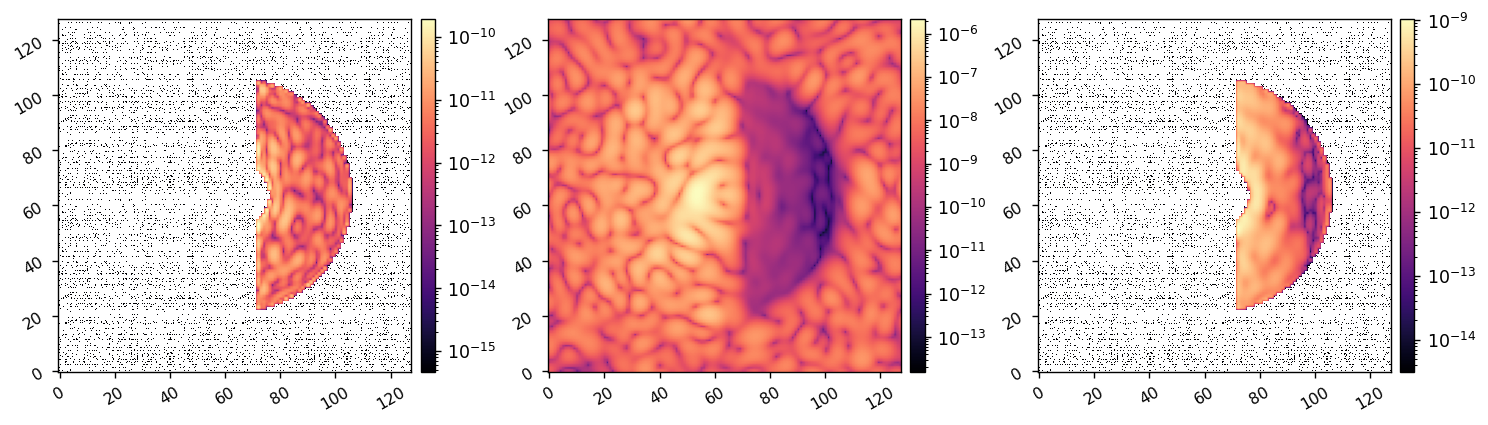

In [19]:
i = 20
I_est = np.abs(efields[i])**2
im = images[i]
diff = np.abs(I_est - im) * dark_mask
misc.imshow3(I_est, im, diff, lognorm=True)

rms_diff = np.sqrt(np.mean(diff[dark_mask]**2))

In [28]:
for i in range(25):
    I_est = np.abs(efields[i])**2
    im = images[i]
    diff = np.abs(I_est - im) * dark_mask
    rms_est = np.sqrt(np.mean(I_est[dark_mask]**2))
    rms_im = np.sqrt(np.mean(im[dark_mask]**2))
    rms_diff = np.sqrt(np.mean(diff[dark_mask]**2))
    print(i, rms_est/rms_im)

0 1.0462563416399746
1 1.0432425901904374
2 1.0394752289566926
3 1.034634270930162
4 1.0281043386085182
5 1.018791012976168
6 1.0048428549463613
7 0.9833282751735143
8 0.9500703300720156
9 0.9000992215228516
10 0.8292976198819778
11 0.7371573625279143
12 0.6289645048700215
13 0.5150405504511596
14 0.4069255901208266
15 0.31326466196115754
16 0.2379453358248333
17 0.18069984154359922
18 0.1388583190972716
19 0.10898227761772977
20 0.0878545418288467
21 0.07785511707485732
22 0.07432418264607489
23 0.06993795865978526
24 0.06362490363430531


In [45]:

misc.save_fits('images\coro_image.fits', np.abs(efields[-1])**2, header={'PIXELSCL':c.psf_pixelscale_lamD,
                                                                         'ITRATION':20})
misc.save_fits('commands\efc_commands.fits', commands[-1][c.dm_mask], header={'ITRATION':20})

Saved data to:  images\coro_image.fits
Saved data to:  commands\efc_commands.fits
